In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras import Input, Model
from keras.layers import Embedding, Dense, Dropout, LSTM, GlobalMaxPool1D, Bidirectional

In [2]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shreyassk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv("updated_train.csv")
test = pd.read_csv("./toxicity-detection/test_set.csv")

In [4]:
def sum_of_columns(dataframe, columns):
    temp = 0
    for col in columns:
        temp += dataframe[col]
    return temp

In [5]:
DETECTION_CLASSES = [
    'toxic',
    'severe_toxic',
    'obscene',
    'threat',
    'insult',
    'identity_hate',
    'neutral']

In [6]:
from data_cleaning import clean_text_column

cols = DETECTION_CLASSES.copy()
cols.remove('neutral')
df['neutral'] = np.where(sum_of_columns(df, cols) > 0, 0, 1)
df['text'] = clean_text_column(df['text'])

test['neutral'] = np.where(sum_of_columns(test, cols) > 0, 0, 1)
test['comment_text'] = clean_text_column(test['comment_text'])
print("Data Cleaned")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shreyassk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Data Cleaned


In [7]:
x_train = df['text'].values
y_train = df[DETECTION_CLASSES].values

In [8]:
x_test = test['comment_text'].values
y_test = test[DETECTION_CLASSES].values

In [9]:
max_features=100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train))
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)

In [10]:
import pickle

with open("tokenizer.pkl", 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
maxpadlen = 200
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [13]:
embedding_dim_fasttext = 300
embeddings_index_fasttext = {}
f = open('./toxicity-detection/wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

embedding_matrix_fasttext = np.random.random((len(tokenizer.word_index) + 1, embedding_dim_fasttext))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
print("Completed!")

Completed!


In [ ]:
# class_weight = {0: 1.4905, 1: 14.2920, 2: 2.6980, 3: 47.69, 4: 2.8939, 5: 16.2244, 6: 0.1590}
# class_weight = {0: 0.000458, 1: 0.004389, 2: 0.000829, 3: 0.014644, 4: 0.000889, 5: 0.004982, 6: 0.000049}

In [14]:
inp=Input(shape=(maxpadlen, ),dtype='int32')
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)
x = LSTM(40, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
preds = Dense(7, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

#Compile the Model.
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[tf.keras.metrics.AUC()])

#Fit the Model on Training Data.
model_info_1=model_1.fit(X_t, y_train, epochs=2, 
                         batch_size=32,
                         validation_split=0.2)

<IPython.core.display.Javascript object>

Epoch 1/2
4235/4235 [==============================] - 212s 50ms/step - loss: 0.1130 - auc: 0.9842 - val_loss: 0.0913 - val_auc: 0.9903
Epoch 2/2
4235/4235 [==============================] - 206s 49ms/step - loss: 0.0895 - auc: 0.9901 - val_loss: 0.0833 - val_auc: 0.9914


In [15]:
model_1.save("lstm_updated.h5")

In [16]:
from keras.models import load_model

lstm = load_model("lstm_updated.h5")

with open("tokenizer.pkl", 'rb') as handle:
    tokenizer = pickle.load(handle)

In [17]:
def predict(comment):
    """
    Makes a prediction call to the NLP Model to get the level of Toxicity
    :param comment: Review Comment
    :return: JSON Response with Toxicity levels predicted by NLP model
    """

    input_comment = clean_text(comment)
    input_comment = input_comment.split(" ")

    sequences = tokenizer.texts_to_sequences(input_comment)
    sequences = [[item for sublist in sequences for item in sublist]]

    padded_data = pad_sequences(sequences, maxlen=200)
    result = lstm.predict(padded_data, len(padded_data), verbose=1)

    return {
            "Toxic": str(result[0][0]),
            "Very Toxic": str(result[0][1]),
            "Obscene": str(result[0][2]),
            "Threat": str(result[0][3]),
            "Insult": str(result[0][4]),
            "Hate": str(result[0][5]),
            "Neutral": str(result[0][6])
        }


In [18]:
from data_cleaning import clean_text

print(predict("DJ Robinson is gay as hell! he sucks his dick so much!!!!!"))
print(predict("Fuck off, you anti-semitic cunt."))
print(predict("How dare you vandalize that page about the HMS Beagle! Don't vandalize again, demon!"))
print(predict("Khoros is awesome"))

1/1 [==============================] - 0s 288ms/step
{'Toxic': '0.97209626', 'Very Toxic': '0.26571327', 'Obscene': '0.86963093', 'Threat': '0.09281194', 'Insult': '0.8476769', 'Hate': '0.8177401', 'Neutral': '0.009884447'}
1/1 [==============================] - 0s 17ms/step
{'Toxic': '0.95577526', 'Very Toxic': '0.23047814', 'Obscene': '0.7853679', 'Threat': '0.074641675', 'Insult': '0.787817', 'Hate': '0.7591281', 'Neutral': '0.017473727'}
1/1 [==============================] - 0s 20ms/step
{'Toxic': '0.19435263', 'Very Toxic': '0.013033569', 'Obscene': '0.048072398', 'Threat': '0.03651017', 'Insult': '0.07070133', 'Hate': '0.04401952', 'Neutral': '0.782662'}
1/1 [==============================] - 0s 16ms/step
{'Toxic': '0.033089995', 'Very Toxic': '0.005406618', 'Obscene': '0.008182436', 'Threat': '0.01166302', 'Insult': '0.018892437', 'Hate': '0.023555845', 'Neutral': '0.9665868'}


In [19]:
score = lstm.evaluate(X_te, y_test, verbose=1)

2000/2000 [==============================] - 42s 21ms/step - loss: 0.1087 - auc: 0.9861


In [20]:
y_pred = lstm.predict(X_te)

In [21]:
ex = y_pred
ex[:] = ex[:]>0.5
ex = ex.astype(int)
ex

array([[0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 1, 1, 0],
       [1, 0, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [22]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay
cm = multilabel_confusion_matrix(y_test, ex)
print(classification_report(y_test,ex))

              precision    recall  f1-score   support

           0       0.50      0.89      0.64      6090
           1       0.45      0.31      0.37       367
           2       0.59      0.79      0.68      3691
           3       0.16      0.50      0.24       211
           4       0.51      0.71      0.59      3427
           5       0.34      0.83      0.48       712
           6       0.99      0.90      0.94     57735

   micro avg       0.84      0.88      0.86     72233
   macro avg       0.51      0.70      0.56     72233
weighted avg       0.89      0.88      0.88     72233
 samples avg       0.88      0.88      0.88     72233



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


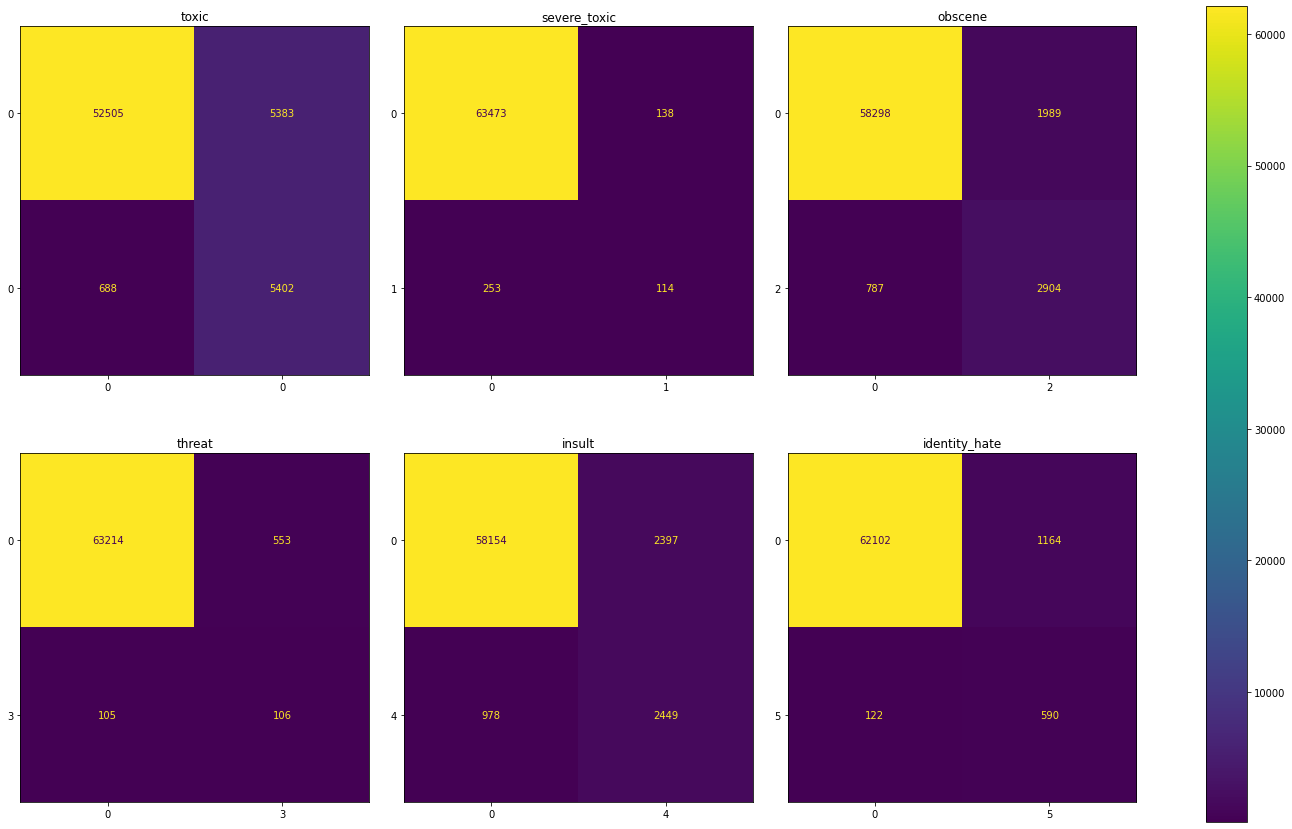

In [23]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                   ex[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.0f')
    disp.ax_.set_title(f'{DETECTION_CLASSES[i]}')
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [24]:
from sklearn.metrics import roc_curve, auc

n_classes = 7 # number of class

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], ex[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), ex.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [25]:
roc_auc

{0: 0.8970190015303886,
 1: 0.6542286334467283,
 2: 0.8768932317008685,
 3: 0.7468487355142244,
 4: 0.8375163680820308,
 5: 0.9051265887529628,
 6: 0.9019283286030679,
 'micro': 0.9215663806042879}

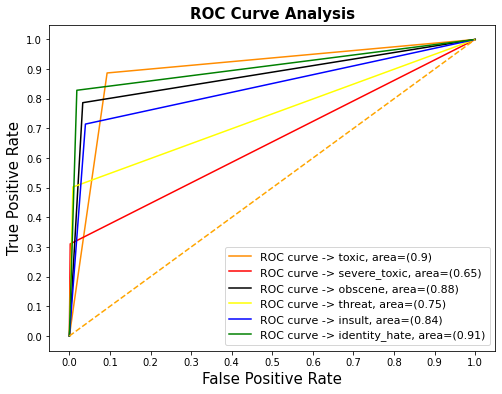

In [26]:
fig = plt.figure(figsize=(8,6))
colors = ['darkorange','red', 'black', 'yellow', 'blue', 'green']
for i in range(6):
    plt.plot(fpr[i], tpr[i], color=colors[i],
            label=f'ROC curve -> {DETECTION_CLASSES[i]}, area=({round(roc_auc[i],2)})')
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':11}, loc='lower right')

plt.show()